# Analyzing Text Data in Annual Reports

1. Open PDF
2. Find MD&A part (use pages from TOC)
3. Count digital transformation related keywords
4. Relevant summary stats
5. Apply PCA(for example) to form a consolidated digital transformation index

In [30]:
import os
import pandas as pd
import numpy as np
import re
import pdfplumber
import jieba
import jieba.analyse
from collections import Counter
from zhon.hanzi import punctuation
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
dtype_dict = {'code': str, 'name': str, 'year': int, 'local_path': str}
df = pd.read_csv('./Data/annual_report_with_path.csv', dtype=dtype_dict)

## 1. Build Digital Transformation Keywords Dictionary

In [12]:
# Report structure changes with time
MDA = {
    2010: "董事会报告",
    2011: '董事会报告',
    2012: '董事会报告',
    2013: '董事会报告',
    2014: '董事会报告',
    2015: '管理层讨论与分析',
    2016: '经营情况讨论与分析',
    2017: '经营情况讨论与分析',
    2018: '经营情况讨论与分析',
    2019: '经营情况讨论与分析',
    2020: '经营情况讨论与分析',
    2021: '管理层讨论与分析',
    2022: '管理层讨论与分析',
    2023: '管理层讨论与分析',
    2024: '管理层讨论与分析'
}

In [13]:
# remove punctuation
def clean_text(text):
    cleaned_text = re.sub(r'[\n\s\W]+', ' ', text)
    cleaned = ''.join(cleaned_text.split())
    return cleaned

In [14]:
# Load stop words
stop_words = [
    line.strip()
    for line in open('stop_words.txt', 'r', encoding='utf-8').readlines()
]
jieba.load_userdict("userdict.txt")

In [15]:
# Digital Transformation Keywords Dictionary
# Reference: 赵宸宇,王文春,李雪松.数字化转型如何影响企业全要素生产率[J].财贸经济, 2021, 42 (07): 114 - 129.
# AI
AI = [
    '人工智能', '高端智能', '工业智能', '移动智能', '智能控制', '智能终端', '智能移动', '智能管理', '智能工厂',
    '智能物流', '智能制造', '智能仓储', '智能技术', '智能设备', '智能生产', '智能网联', '智能系统', '智能化',
    '自动控制', '自动监测', '自动监控', '自动检测', '自动生产', '数控', '一体化', '集成化', '集成解决方案',
    '集成控制', '集成系统', '工业云', '未来工厂', '智能故障诊断', '生命周期管理', '生产制造执行系统', '虚拟化',
    '虚拟制造'
]
# Big Data
Data = [
    '数据管理', '数据挖掘', '数据网络', '数据平台', '数据中心', '数据科学', '数字控制', '数字技术', '数字通信',
    '数字网络', '数字智能', '数字终端', '数字营销', '数字化', '大数据', '云计算', '云IT', '云生态', '云服务',
    '云平台', '区块链', '物联网', '机器学习'
]
# Information Technology
Info = [
    '信息共享', '信息管理', '信息集成', '信息软件', '信息系统', '信息网络', '信息终端', '信息中心', '信息化',
    '网络化', '工业信息', '工业通信'
]
# Commercialiation
Comm = [
    '移动互联网', '工业互联网', '产业互联网', '互联网解决方案', '互联网技术', '互联网思维', '互联网行动', '互联网业务',
    '互联网移动', '互联网应用', '互联网营销', '互联网战略', '互联网平台', '互联网模式', '互联网商业模式', '互联网生态',
    '电商', '电子商务', 'Internet', '互联网+', '线上线下', '线上到线下', '线上和线下', 'O2O', 'B2B',
    'C2C', 'B2C', 'C2B'
]

## 2. Count work frequency

In [38]:
words_count = pd.DataFrame(
    columns=['code', 'year', 'AI', 'Data', 'Info', 'Comm', 'length'])

In [39]:
for i in range(50):

    pdf_file_path = df['local_path'][i]
    code = df['code'][i]
    year = df['year'][i]

    # initialize
    word_count_AI = {word: 0 for word in AI}
    word_count_Data = {word: 0 for word in Data}
    word_count_Info = {word: 0 for word in Info}
    word_count_Comm = {word: 0 for word in Comm}

    year = df['year'][i]

    mda = MDA[year]

    # open PDF file
    try:
        with pdfplumber.open(pdf_file_path) as pdf:
            text = ''

            # locate the start and end page of MD&A
            is_toc = False

            for page in pdf.pages:
                if '目录' in page.extract_text() and '三' in page.extract_text(
                ) and '四' in page.extract_text() and '七' in page.extract_text(
                ):
                    is_toc = True
                    toc = clean_text(page.extract_text())
                    break
            if is_toc:
                match = re.search(rf'{mda}(\d+).*?(\d+)', toc)
                if match:
                    start_page = int(match.group(1))  # start page
                    end_page = int(match.group(2))  # end page

            try:

                # extract text from MD&A
                for page_num in range(start_page - 1, end_page):
                    try:
                        page = pdf.pages[page_num]
                        text += page.extract_text()
                    except IndexError:
                        print(f'{i}页码有误')
                        break

                # delete chapter before and after MD&A
                content = clean_text(text)
                # matches = re.findall(rf'第\w节({mda}.*?)第\w节', cleaned_text)
                # content = ''.join(matches)
                length = len(content)

                # count words frequency
                # cut the text into words
                words = jieba.lcut(content)

                for word in words:
                    if word in AI:
                        word_count_AI[word] += 1
                    elif word in Data:
                        word_count_Data[word] += 1
                    elif word in Info:
                        word_count_Info[word] += 1
                    elif word in Comm:
                        word_count_Comm[word] += 1

                # calculate the total number of words
                AI_words = sum(word_count_AI.values())
                Data_words = sum(word_count_Data.values())
                Info_words = sum(word_count_Info.values())
                Comm_words = sum(word_count_Comm.values())

                record = {
                    'code': code,
                    'year': year,
                    'AI': AI_words,
                    'Data': Data_words,
                    'Info': Info_words,
                    'Comm': Comm_words,
                    'length': length
                }
                words_count = words_count._append(record, ignore_index=True)
                print(f"{i+1} completed.")
            except NameError:
                print(f'{i}页码有误')

    except FileNotFoundError:
        print('PDF not found')

1 completed.
2 completed.
3 completed.
4 completed.
5 completed.
6 completed.
7 completed.
8 completed.
9 completed.
10 completed.
11 completed.
12 completed.
13 completed.
14 completed.
15 completed.
16 completed.
17 completed.
18 completed.
19 completed.
20 completed.
21 completed.
22 completed.
23 completed.
PDF not found
25 completed.
26 completed.
27 completed.
28 completed.
29 completed.
30 completed.
31 completed.
32 completed.
33 completed.
34 completed.
35 completed.
36 completed.
37 completed.
38 completed.
39 completed.
40 completed.
41 completed.
42 completed.
43 completed.
44 completed.
45 completed.
46 completed.
47 completed.
48 completed.
49 completed.
PDF not found


In [41]:
words_count

,code,year,AI,Data,Info,Comm,length
0,603019,2024,26,66,2,0,16951
1,872808,2024,10,170,5,1,21960
2,300353,2024,147,28,22,19,32570
3,000063,2024,32,42,2,4,33933
4,688041,2024,37,20,4,0,24071
5,300437,2023,13,1,1,8,23689
6,300437,2022,16,3,0,13,23608
7,300437,2018,5,0,0,0,22094
8,300437,2017,5,0,1,0,23397
9,300437,2021,31,4,1,12,30622


## 3. Summary Stats

In [42]:
words_count.iloc[:,2:].astype(int).describe()

,AI,Data,Info,Comm,length
count,48.000000,48.000000,48.000000,48.000000,48.000000
mean,16.729167,15.958333,3.458333,4.541667,25460.229167
std,24.264272,30.919909,4.771183,9.864957,9919.947403
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,0.000000,0.000000,0.000000,19990.000000
50%,10.000000,5.000000,2.000000,1.000000,23772.000000
75%,19.000000,20.250000,3.250000,5.000000,30559.000000
max,147.000000,170.000000,22.000000,63.000000,64292.000000


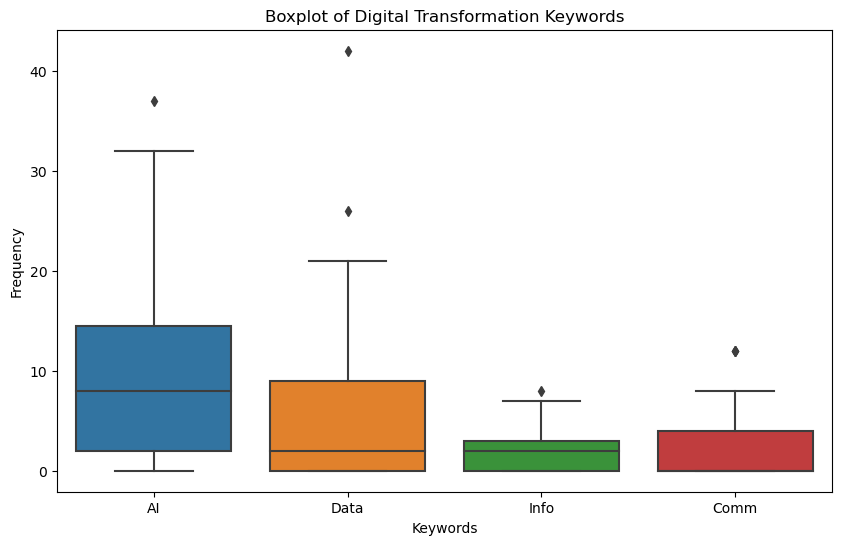

In [43]:
# Convert columns to numeric
# Remove extreme outliers
Q1 = words_count[['AI', 'Data', 'Info', 'Comm']].quantile(0.25)
Q3 = words_count[['AI', 'Data', 'Info', 'Comm']].quantile(0.75)
IQR = Q3 - Q1
words_count_no_outlier = words_count[~((words_count[['AI', 'Data', 'Info', 'Comm']] < (Q1 - 1.5 * IQR)) | (words_count[['AI', 'Data', 'Info', 'Comm']] > (Q3 + 1.5 * IQR))).any(axis=1)]
words_count_no_outlier[['AI', 'Data', 'Info', 'Comm']] = words_count[['AI', 'Data', 'Info', 'Comm']].apply(pd.to_numeric)

# Plot boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=words_count_no_outlier[['AI', 'Data', 'Info', 'Comm']])
plt.title('Boxplot of Digital Transformation Keywords')
plt.ylabel('Frequency')
plt.xlabel('Keywords')
plt.show()

## 4. Construct a Digital-Transformation Index

In [46]:
target_columns = ['AI', 'Comm', 'Info', 'Data']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(words_count[target_columns])

scaled_df = pd.DataFrame(scaled_data, columns=target_columns)

In [47]:
# PCA
pca = PCA()
pca.fit(scaled_df)

# explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

print(cumulative_explained_variance_ratio)

[0.47132924 0.73035107 0.91280327 1.        ]


In [ ]:
# first PC can explain 47% of the variance
# use PC1 as the index
pca = PCA(n_components=1)
component_scores = pca.fit_transform(scaled_df)

# add the component score to the dataframe
words_count['DT_Index'] = component_scores

In [52]:
result = words_count.merge(df, on=['code', 'year']).drop(columns=['local_path'])

In [53]:
result.sort_values(by='DT_Index', ascending=False)[['code', 'name', 'year', 'DT_Index']].head(10)

,code,name,year,DT_Index
2,300353,东土科技,2024,6.208709
26,688100,威胜信息,2024,3.975292
1,872808,曙光数创,2024,2.236677
41,002808,ST恒久,2021,1.884703
40,002808,ST恒久,2022,1.521421
24,600535,天士力,2024,1.429463
36,002413,雷科防务,2023,1.318620
0,603019,中科曙光,2024,0.713972
31,002097,山河智能,2023,0.651768
4,688041,海光信息,2024,0.594122


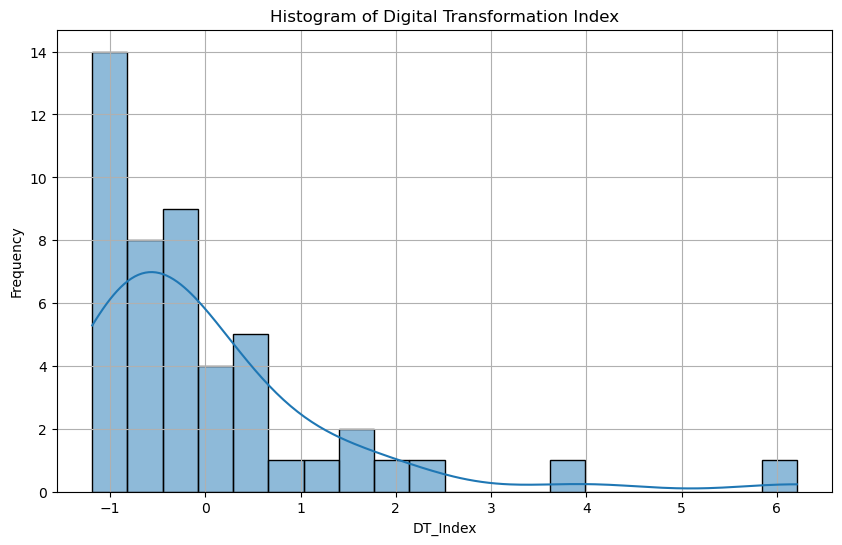

In [57]:
plt.figure(figsize=(10, 6))
sns.histplot(words_count['DT_Index'], bins=20, kde=True)
plt.title('Histogram of Digital Transformation Index')
plt.xlabel('DT_Index')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

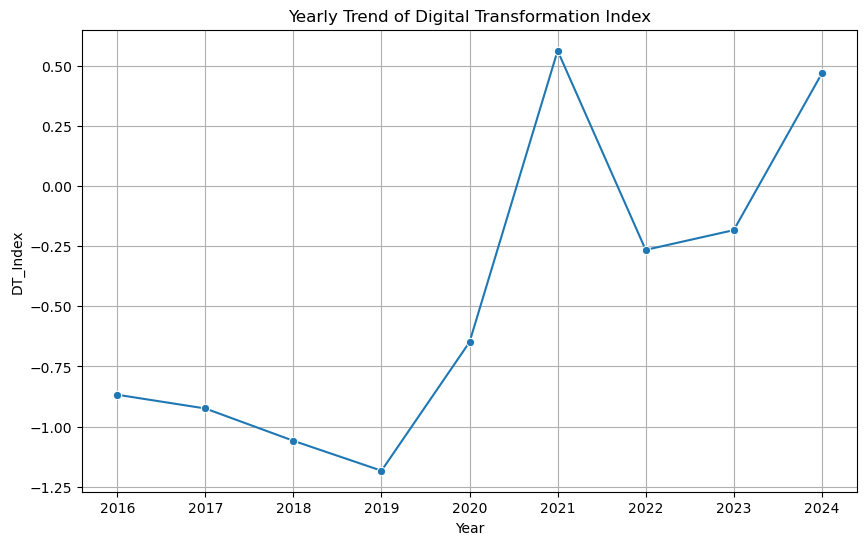

In [56]:
# Group by year and calculate the mean DT_Index for each year
yearly_trend = words_count.groupby('year')['DT_Index'].mean().reset_index()

# Plot the trend
plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_trend, x='year', y='DT_Index', marker='o')
plt.title('Yearly Trend of Digital Transformation Index')
plt.xlabel('Year')
plt.ylabel('DT_Index')
plt.grid(True)
plt.show()

In [55]:
result.to_csv('./Data/DT_Index.csv', index=False)